In [22]:
import igraph
from translation import FJSSPInstancesTranslator, SequenceGAEncoder
from model import ProductionEnvironment, Order

In [23]:
graph = igraph.Graph(n=10, edges=[(0,1),(1,2),(0,2),(3,4),(3,5),(5,6),(6,7),(5,8),(6,8),(0,9),(8,9)])

vertices = graph.vs
edges = graph.es

duration_weights = [10, 5, 10, 3, 7, 4, 6, 5, 4, 2, 7]
graph.es["duration"] = duration_weights
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
graph.vs["value"] = values
print(graph)

IGRAPH U--- 10 11 --
+ attr: value (v), duration (e)
+ edges:
0--1 1--2 0--2 3--4 3--5 5--6 6--7 5--8 6--8 0--9 8--9


In [24]:
graph.vs["type"] = [1, 1, 0, 0, 1, 0, 1, 1, 1, 0]

<AxesSubplot: title={'center': 'Full Graph'}>

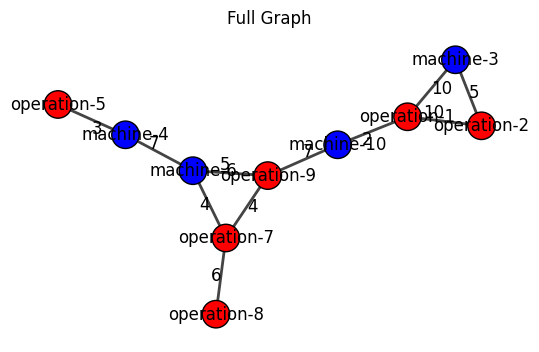

In [25]:
import matplotlib.pyplot as plt

visual_style = {}
visual_style["vertex_color"] = ["blue" if value == 0 else "red" for value in graph.vs["type"]]
visual_style["vertex_label"] = [f"machine-{graph.vs['value'][i]}" if graph.vs["type"][i] == 0 else f"operation-{graph.vs['value'][i]}" for i in range(len(graph.vs["type"]))]
#visual_style["vertex_label"] = ["machine" if value == 0 else "operation" for value in graph.vs["type"]]
visual_style["edge_label"] = [str(duration) for duration in graph.es["duration"]]
#visual_style["layout"] = graph.layout_kamada_kawai()
fig, ax = plt.subplots()

ax.set_title("Full Graph")
igraph.plot(graph, target=ax, **visual_style)


Use actual instance

In [26]:
benchmark_base_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\upgrades\code\benchmarks\\'
def read_benchmark_file(source, instance):
    if source.startswith('0'):
        target_file = f'Behnke{instance}.fjs'
    elif source.startswith('1'):
        target_file = f'BrandimarteMk{instance}.fjs'
    elif source.startswith('2a'):
        target_file = f'HurinkSdata{instance}.fjs'
    elif source.startswith('2b'):
        target_file = f'HurinkEdata{instance}.fjs'
    elif source.startswith('2c'):
        target_file = f'HurinkRdata{instance}.fjs'
    elif source.startswith('2d'):
        target_file = f'HurinkVdata{instance}.fjs'
    elif source.startswith('3'):
        target_file = f'DPpaulli{instance}.fjs'
    elif source.startswith('4'):
        target_file = f'ChambersBarnes{instance}.fjs'
    elif source.startswith('5'):
        target_file = f'Kacem{instance}.fjs'
    elif source.startswith('6'):
        target_file = f'Fattahi{instance}.fjs'
    path = benchmark_base_path + f'{source}\\{target_file}'
    return open(path, 'r').readlines()

In [27]:
def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

In [28]:
source = '5_Kacem'
instance = 1
production_environment = FJSSPInstancesTranslator().translate(source, instance)
orders = generate_one_order_per_recipe(production_environment)
production_environment.orders = orders
workstations_per_operation, durations, job_operations = SequenceGAEncoder().encode(production_environment, orders)


In [29]:
n_operations = len(durations)
n_machines = len(durations[0])

In [30]:
types = [0] * n_machines
types.extend([1] * n_operations)
names = [f'm-{i}' for i in range(n_machines)]
o_ids = ['j0-o0']
o_id = 1
job_edges = []
for i in range(1, len(job_operations)):
    if job_operations[i] != job_operations[i-1]:
        o_id = 0
    else:
        job_edges.append((n_machines+i-1, n_machines+i))
    o_ids.append(f'j{job_operations[i]}-o{o_id}')
    o_id += 1
names.extend(o_ids)

In [31]:
duration_edges = []
duration_weights = []

for i in range(len(durations)):
    duration = durations[i]
    operation_idx = n_machines + i
    for machine in range(len(duration)):
        if duration[machine] > 0:
            duration_edges.append((operation_idx, machine))
            duration_weights.append(duration[machine])



In [32]:
edges = duration_edges
edges.extend(job_edges)
duration_weights.extend([0] * len(job_edges))

In [33]:
graph = igraph.Graph(n=len(types), edges=duration_edges, directed=True)
graph.es["duration"] = duration_weights

graph.vs["type"] = types
graph.vs["name"] = names

<AxesSubplot: title={'center': '5_Kacem - 1: Full Graph'}>

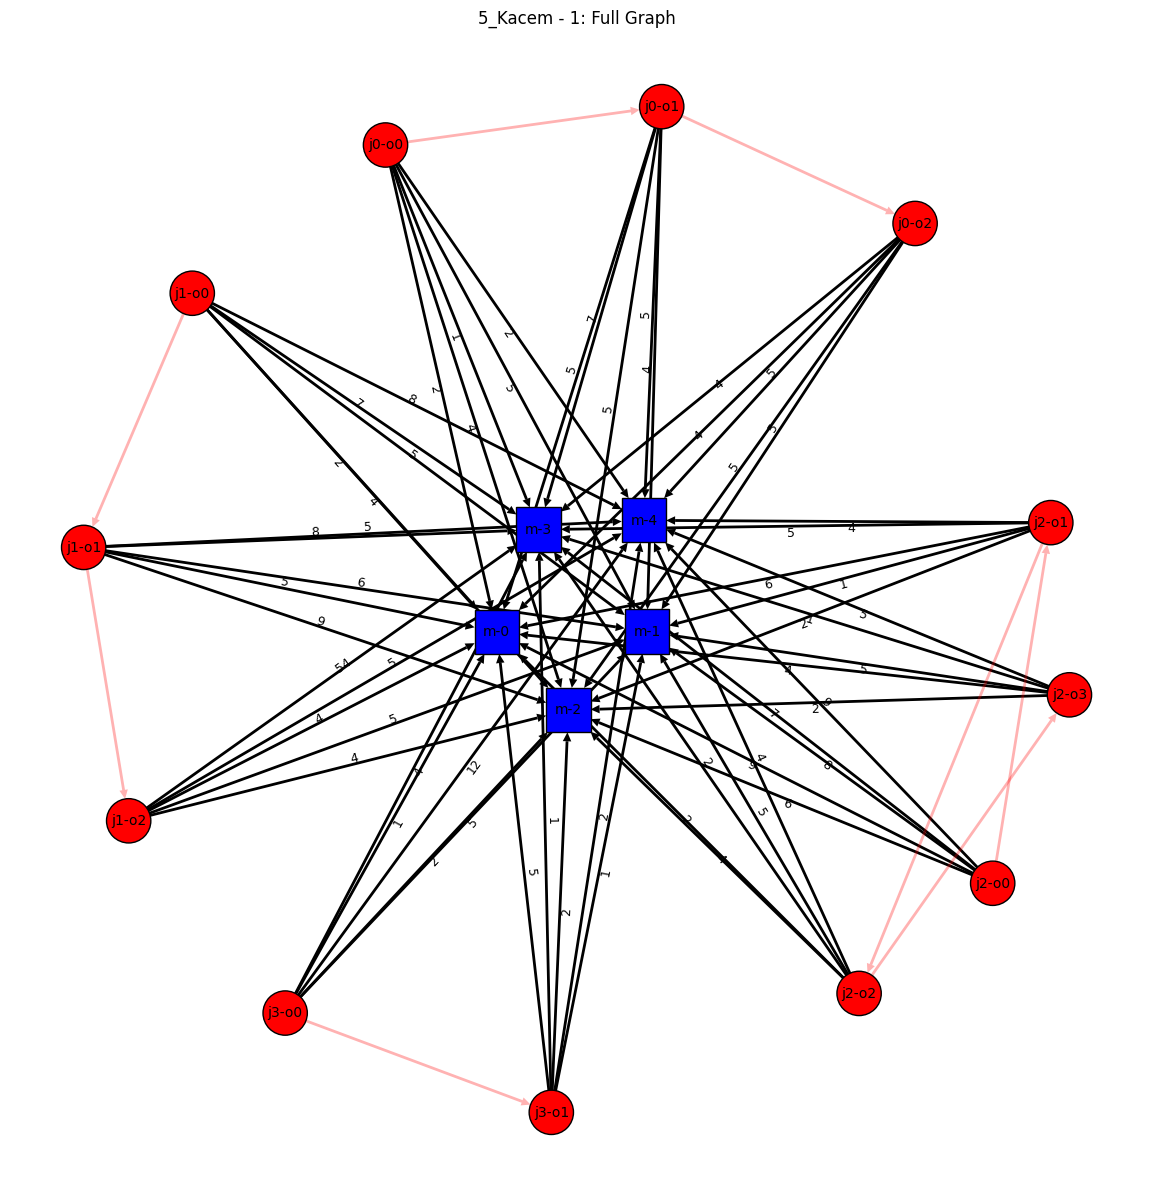

In [34]:
import matplotlib.pyplot as plt

visual_style = {}
visual_style["vertex_color"] = ["blue" if value == 0 else "red" for value in graph.vs["type"]]
visual_style["vertex_label"] = [graph.vs["name"][i] for i in range(len(graph.vs["type"]))]
visual_style["edge_label"] = [str(duration) if duration > 0 else '' for duration in graph.es["duration"]]
colors = ['black' if duration > 0 else (1.0, 0.0, 0.0, 0.3) for duration in graph.es["duration"]]
# visual config
visual_style["bbox"] = (1024, 1024)
#visual_style["margin"] = 10
visual_style["layout"] = 'kk'
visual_style["edge_align_label"] = True
visual_style["edge_arrow_size"] = 0.003
visual_style["edge_label_size"] = 9
visual_style["vertex_shape"] = ['rectangle' if value == 0 else 'circle' for value in graph.vs["type"]]
visual_style["vertex_label_size"] = 10
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
ax.set_title(f"{source} - {instance}: Full Graph")
igraph.plot(graph, target=ax, edge_color=colors, **visual_style)


In [35]:
spanning_tree = graph.spanning_tree()

<AxesSubplot: title={'center': 'Spanning Tree'}>

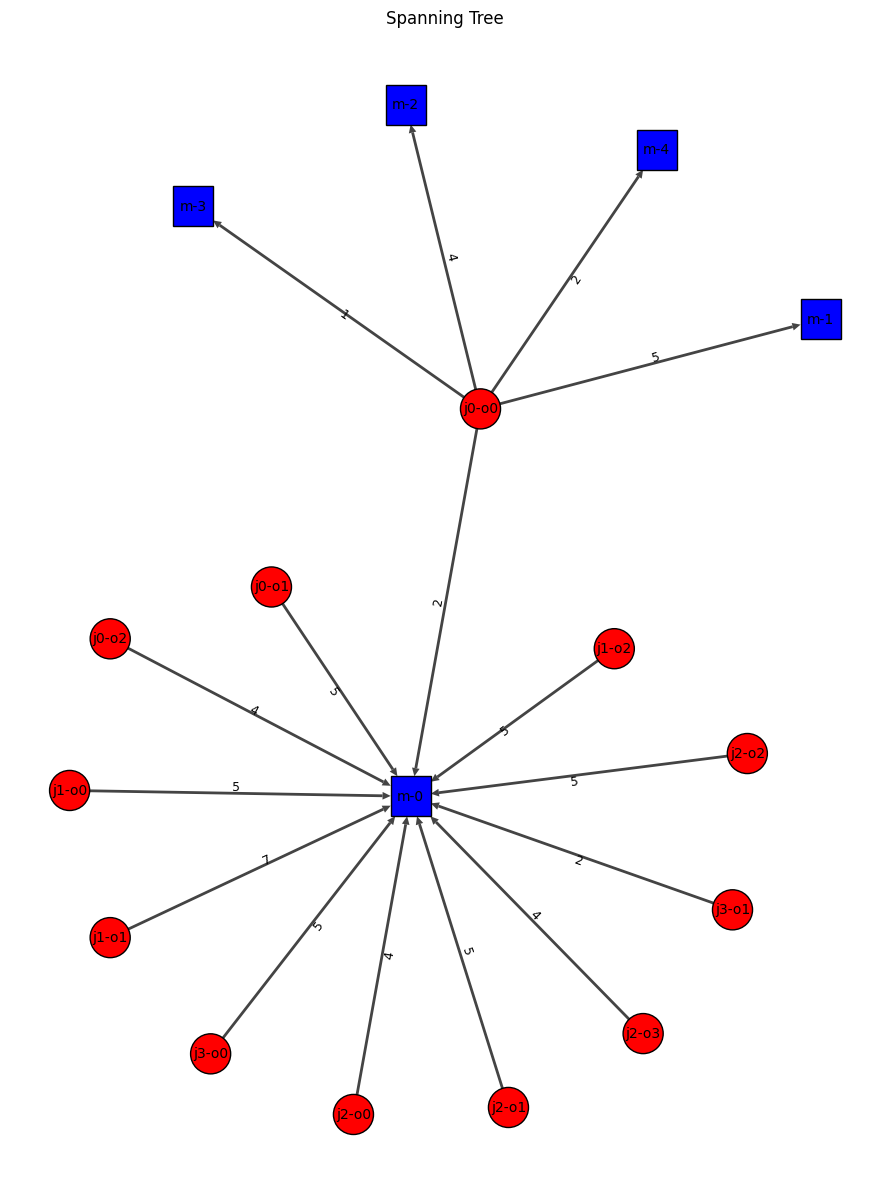

In [36]:
fig2, ax2 = plt.subplots()
fig2.set_figheight(15)
fig2.set_figwidth(15)
ax2.set_title("Spanning Tree")
igraph.plot(spanning_tree, target=ax2, **visual_style)

In [37]:
machine_possibilities = []
machine_durations = []
for i in range(n_machines):
    machine_possibilities.append([])
    machine_durations.append([])
for i in range(len(durations)):
    count = 0
    for j in range(len(durations[i])):
        if durations[i][j] > 0:
            count+=1
            machine_durations[j].append(durations[i][j])
    for j in range(len(machine_possibilities)):
        if durations[i][j] > 0:
            machine_possibilities[j].append(count)


In [38]:
avg_possible_assignments = [0] * n_machines
avg_machine_durations = [0] * n_machines
for i in range(len(machine_possibilities)):
    avg_possible_assignments[i] = sum(machine_possibilities[i])/len(machine_possibilities[i])
    avg_machine_durations[i] = sum(machine_durations[i])/len(machine_durations[i])
machine_durations_above_avg = [sum([1 if durations[i][j] > avg_machine_durations[j] else 0 for i in range(len(durations))]) for j in range(n_machines)]
avg_operation_durations = [sum(durations[i])/len(durations[i]) for i in range(len(durations))]
operation_durations_above_avg = [sum([1 if durations[i][j] > avg_operation_durations[i] else 0 for j in range(len(durations[i]))]) for i in range(len(durations))]

In [39]:
print(avg_possible_assignments)
print(avg_machine_durations)
print(machine_durations_above_avg)
print(avg_operation_durations)
print(operation_durations_above_avg)

[5.0, 5.0, 5.0, 5.0, 5.0]
[4.083333333333333, 4.583333333333333, 4.083333333333333, 8.416666666666666, 5.5]
[5, 9, 4, 1, 3]
[2.8, 5.2, 4.6, 5.2, 6.6, 14.4, 7.8, 3.6, 3.4, 3.4, 4.8, 2.2]
[2, 1, 3, 2, 2, 1, 3, 3, 3, 3, 2, 1]


In [40]:
print(n_machines)
print(n_operations)

5
12


In [41]:
# portion of operations on each machine > average duration
print([x/n_operations for x in machine_durations_above_avg])

[0.4166666666666667, 0.75, 0.3333333333333333, 0.08333333333333333, 0.25]


In [42]:
# portion of machines for operation > average duration
print([x/n_machines for x in operation_durations_above_avg])

[0.4, 0.2, 0.6, 0.4, 0.4, 0.2, 0.6, 0.6, 0.6, 0.6, 0.4, 0.2]
